In [1]:
import functools
import logging
import glob
import os

In [118]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy import stats

In [3]:
import util
import matching
import tomography
import weights

In [16]:
# from https://github.com/beckermr/des-y6-analysis/blob/main/2024_10_21_fgmodels/des_y6_nz_modeling.py
def sompz_integral(y, x, low, high):
    low = np.minimum(x[-1], np.maximum(low, x[0]))
    high = np.minimum(x[-1], np.maximum(high, x[0]))
    low_ind = np.digitize(low, x)
    # for the lower index we do not use right=True, but
    # we still want to clip to a valid index of x
    low_ind = np.minimum(low_ind, x.shape[0] - 1)
    high_ind = np.digitize(high, x, right=True)
    dx = x[1:] - x[:-1]

    # high point not in same bin as low point
    not_in_single_bin = high_ind > low_ind

    # fractional bit on the left
    ileft = np.where(
        not_in_single_bin,
        (y[low_ind - 1] + y[low_ind])
        / 2.0
        * (1.0 - (low - x[low_ind - 1]) / dx[low_ind - 1])
        * dx[low_ind - 1],
        (y[low_ind - 1] + y[low_ind]) / 2.0 * (high - low),
    )

    # fractional bit on the right
    iright = np.where(
        not_in_single_bin,
        (y[high_ind - 1] + y[high_ind]) / 2.0 * (high - x[high_ind - 1]),
        0.0,
    )

    # central bits
    yint = (y[1:] + y[:-1]) / 2.0 * dx
    yind = np.arange(yint.shape[0])
    msk = (yind >= low_ind) & (yind < high_ind - 1)
    icen = np.where(
        np.any(msk),
        np.sum(
            np.where(
                msk,
                yint,
                np.zeros_like(yint),
            )
        ),
        0.0,
    )

    return ileft + icen + iright

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

In [5]:
SHEAR_STEPS = [
    'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0',
    'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.6__zhigh=0.9',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.8__zhigh=2.1',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.9__zhigh=1.2',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.1__zhigh=2.4',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.0__zhigh=0.3',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.2__zhigh=1.5',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.4__zhigh=2.7',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.3__zhigh=0.6',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.5__zhigh=1.8',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.7__zhigh=6.0',
]
TOMOGRAPHIC_BINS = [0, 1, 2, 3]
CELL_IDS = list(range(1024 + 1))
MDET_STEPS = ["noshear", "1p", "1m", "2p", "2m"]

BANDS = ["g", "r", "i", "z"]

ZVALS = np.array([
    0.   , 0.035, 0.085, 0.135, 0.185, 0.235, 0.285, 0.335, 0.385,
    0.435, 0.485, 0.535, 0.585, 0.635, 0.685, 0.735, 0.785, 0.835,
    0.885, 0.935, 0.985, 1.035, 1.085, 1.135, 1.185, 1.235, 1.285,
    1.335, 1.385, 1.435, 1.485, 1.535, 1.585, 1.635, 1.685, 1.735,
    1.785, 1.835, 1.885, 1.935, 1.985, 2.035, 2.085, 2.135, 2.185,
    2.235, 2.285, 2.335, 2.385, 2.435, 2.485, 2.535, 2.585, 2.635,
    2.685, 2.735, 2.785, 2.835, 2.885, 2.935, 2.985])
ZEDGES = np.array([0.  , 0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46,
       0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96, 1.01,
       1.06, 1.11, 1.16, 1.21, 1.26, 1.31, 1.36, 1.41, 1.46, 1.51, 1.56,
       1.61, 1.66, 1.71, 1.76, 1.81, 1.86, 1.91, 1.96, 2.01, 2.06, 2.11,
       2.16, 2.21, 2.26, 2.31, 2.36, 2.41, 2.46, 2.51, 2.56, 2.61, 2.66,
       2.71, 2.76, 2.81, 2.86, 2.91, 2.96, 3.01])

In [12]:
shear_step_plus = 'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'
shear_step_minus = 'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'

In [14]:
tomo_colors = {
    0: "blue",
    1: "gold",
    2: "green",
    3: "red",
}
tomographic_bins = [0, 1, 2, 3]

In [7]:
imsim_base = "/global/cfs/cdirs/des/y6-image-sims/fiducial-400/"
imsim_catalogs = {
    shear_step: os.path.join(
        imsim_base,
        shear_step,
        "metadetect_cutsv6_all.h5",
    )
    for shear_step in SHEAR_STEPS
}
hf_imsim_dict = {
    shear_step: h5py.File(imsim_catalog, mode="r")
    for shear_step, imsim_catalog in imsim_catalogs.items()
}

In [8]:
redshift_base = "/global/cfs/cdirs/des/y6-redshift/imsim_400Tile/fidbin_S005/"
redshift_catalogs = {
    shear_step: os.path.join(
        redshift_base,
        f"{shear_step}_sompz_unblind_fidbin.h5"
    )
    for shear_step in SHEAR_STEPS
}
hf_redshift_dict = {
    shear_step: h5py.File(redshift_catalog, mode="r")
    for shear_step, redshift_catalog in redshift_catalogs.items()
}

In [10]:
hf_match_dict = {
    shear_step: h5py.File(f"match_{shear_step}.hdf5", mode="r")
    for shear_step in SHEAR_STEPS
}

In [17]:
zbinsc = hf_redshift_dict[shear_step_plus]["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]

zc = np.concatenate([[0.0], zbinsc])

nz_sompz = {}
for tomographic_bin in tomographic_bins:
    _nz_p = hf_redshift_dict[shear_step_plus]["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_p = np.concatenate([[0.0], _nz_p])
    
    _nz_p = _nz_p / np.asarray(sompz_integral(_nz_p, zc, 0, 6.0))
    
    
    _nz_m = hf_redshift_dict[shear_step_minus]["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_m = np.concatenate([[0.0], _nz_m])
    
    _nz_m = _nz_m / np.asarray(sompz_integral(_nz_m, zc, 0, 6.0))

    
    nz_sompz[tomographic_bin] = (_nz_p + _nz_m) / 2 
    
nz_sompz[-1] = (nz_sompz[0] + nz_sompz[1] + nz_sompz[2] + nz_sompz[3]) / 4

---

In [19]:
import tomographic_matching

In [21]:
bhat = tomographic_matching.get_bhat(
    hf_imsim_dict[shear_step_plus],
    hf_redshift_dict[shear_step_plus],
)
assignments = tomographic_matching.get_assignments(
    hf_imsim_dict[shear_step_plus],
    hf_redshift_dict[shear_step_plus],
)
statistical_weights = tomographic_matching.get_statistical_weights(
    hf_imsim_dict[shear_step_plus],
)
g1 = tomographic_matching.get_g1(
    hf_imsim_dict[shear_step_plus],
)
g2 = tomographic_matching.get_g2(
    hf_imsim_dict[shear_step_plus],
)

In [30]:
response_grid = tomographic_matching.get_response_grid(g1, g2, assignments, statistical_weights)

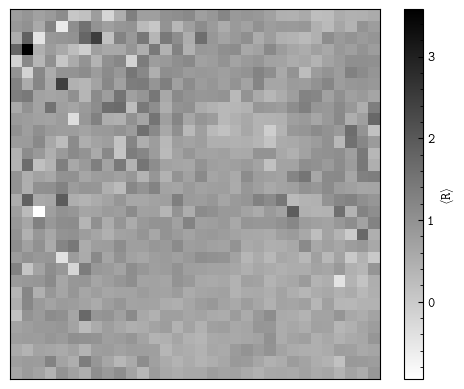

In [98]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    response_grid.reshape(32, 32),
    origin="lower",
)
fig.colorbar(m, label="$\\langle R \\rangle$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [34]:
weight_grid = tomographic_matching.get_weight_grid(assignments, statistical_weights)

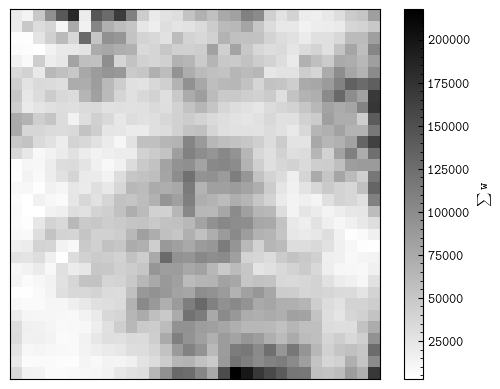

In [97]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    weight_grid.reshape(32, 32),
    origin="lower",
)
fig.colorbar(m, label="$\\sum w$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [38]:
nz, zedges = tomographic_matching.get_redshift_distribution(hf_match_dict[shear_step_plus], assignments, statistical_weights)

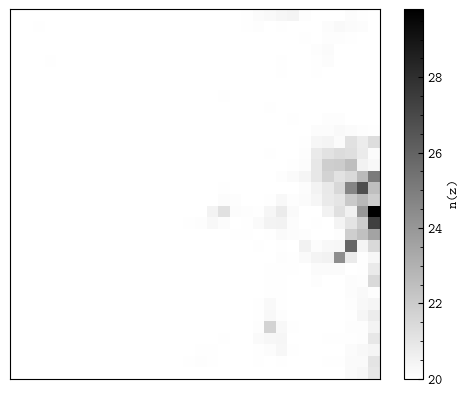

In [96]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    np.sum(nz, axis=1).reshape(32, 32),
    origin="lower",
)
fig.colorbar(m, label="$n(z)$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [62]:
nz_tomo = tomographic_matching.get_tomographic_redshift_distribution(nz, response_grid, weight_grid, assignments, bhat)

In [75]:
cell_assignments = {}
for tomographic_bin in TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        assignments["noshear"][bhat == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

nz_tomo = {}
for tomographic_bin in TOMOGRAPHIC_BINS:
    nz_tomo[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]] \
        * response_grid[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid[cell_assignments[tomographic_bin], np.newaxis],
        axis=0
    ) / np.sum(
        response_grid[cell_assignments[tomographic_bin]] \
        * weight_grid[cell_assignments[tomographic_bin]]
    )
    # manually force n(0) = 0
    nz_tomo[tomographic_bin][0] = 0

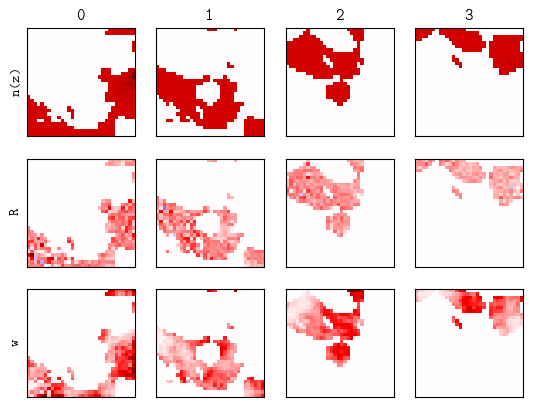

In [134]:
fig, axs = plt.subplots(3, len(TOMOGRAPHIC_BINS), sharex=True, sharey=True)

nz_norm = mpl.colors.CenteredNorm()
r_norm = mpl.colors.CenteredNorm()
w_norm = mpl.colors.CenteredNorm()

for tomographic_bin in TOMOGRAPHIC_BINS:
    _nz = np.zeros_like(nz)
    _r = np.zeros_like(nz)
    _w = np.zeros_like(nz)
    
    _nz[cell_assignments[tomographic_bin]] = nz[cell_assignments[tomographic_bin]]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)
        
    axs[0, tomographic_bin].imshow(
        np.sum(_nz, axis=1).reshape(32, 32),
        norm=nz_norm,
        cmap="seismic",
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_r, axis=1).reshape(32, 32),
        norm=r_norm,
        cmap="seismic",
    )
    
    axs[2, tomographic_bin].imshow(
        np.sum(_w, axis=1).reshape(32, 32),
        norm=w_norm,
        cmap="seismic",
    )

axs[0, 0].set_ylabel("$n(z)$")
axs[1, 0].set_ylabel("$R$")
axs[2, 0].set_ylabel("$w$")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

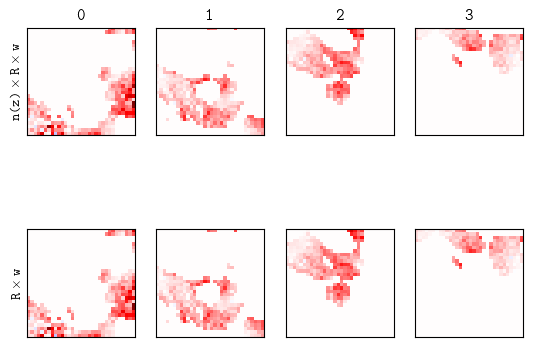

In [133]:
fig, axs = plt.subplots(2, len(TOMOGRAPHIC_BINS), sharex=True, sharey=True)

nz_norm = mpl.colors.CenteredNorm()
r_norm = mpl.colors.CenteredNorm()

for tomographic_bin in TOMOGRAPHIC_BINS:
    _nz = np.zeros_like(nz)
    _r = np.zeros_like(nz)
    _w = np.zeros_like(nz)
    
    _nz[cell_assignments[tomographic_bin]] = nz[cell_assignments[tomographic_bin]]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)
        
    axs[0, tomographic_bin].imshow(
        np.sum(_nz * _r * _w, axis=1).reshape(32, 32),
        norm=nz_norm,
        cmap="seismic",
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_r * _w, axis=1).reshape(32, 32),
        norm=r_norm,
        cmap="seismic",
    )


axs[0, 0].set_ylabel("$n(z) \\times R \\times w$")
axs[1, 0].set_ylabel("$R \\times w$")


for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()